In [48]:
import torch
device = "mps"
def generate_grid_edges(n, m):
    edges = []
    for i in range(n):
        for j in range(m):
            current = i * m + j
            if i > 0: edges.append((current, (i - 1) * m + j, "north"))
            if i < n - 1: edges.append((current, (i + 1) * m + j, "south"))
            if j < m - 1: edges.append( (current, i * m + (j + 1), "east"))
            if j > 0: edges.append((current, i * m + (j - 1), "west"))# West edge

    return {"edges": edges}

In [49]:
from core.spatial.energy_graph import PointEnergyMLP
from core.spatial.diffusion import samples, ScheduleLogLinear, training_loop


constraints = {
    "north": [2, 2],
    "south": [2, 2],
    "east":  [2, 2],
    "west":  [2, 2],
    "northeast": [2, 2],
    "northwest": [2, 2],
    "southeast": [2, 2],
    "southwest": [2, 2]
    }

state_path = "outputs/checkpoints/direction_state.pth"

model = PointEnergyMLP(constraints, dim = 2)
model.load_state_dict(torch.load(state_path, map_location = device))


schedule = ScheduleLogLinear(N=200, sigma_min=0.005, sigma_max=10)
#trainer  = training_loop(loader, model, schedule, epochs=000)
#losses   = [ns.loss.item() for ns in trainer]

n, m = (8,5)
cond = generate_grid_edges(n, m)
batchsize = n * m

xt = torch.randn([1,batchsize,2])  * schedule.sample_sigmas(200)[0]
*xt, x0  = samples(model, schedule.sample_sigmas(200), gam=2, cond = cond, batchsize = batchsize, xt = xt)

print("Solution:")
print(x0[0].cpu().detach().numpy())

from domains.spatial.direction_domain import direction_executor
direction_executor.visualize(x0[0].cpu(), "outputs/dir_cons")
import matplotlib.pyplot as plt

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/opt/anaconda3/envs/soulforge/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/ms/qbhhrxd119555wkjspljcjcc0000gn/T/ipykernel_47606/196168407.py", line 31, in <module>
    *xt, x0  = samples(model, schedule.sample_sigmas(200), gam=2, cond = cond, batchsize = batchsize, xt = xt)
  File "/Users/sunyiqi/Documents/GitHub/MetaLearner/core/spatial/diffusion.py", line 217, in samples
    eps_prev, eps = eps, model.predict_eps_cfg(xt, sig.to(xt), cond, cfg_scale)
  File "/Users/sunyiqi/Documents/GitHub/MetaLearner/core/spatial/energy_graph.py", line 49, in predict_eps_cfg
    return self.predict_eps(x, sigma, cond)
  File "/Users/sunyiqi/Documents/GitHub/MetaLearner/core/spatial/energy_graph.py", line 40, in predict_eps
    return self(x, sigma, cond=cond)["gradient"]
  File "/opt/anaconda3/envs/soulforge/lib/python3.9/site-packages/torch/nn/

SwissLearner

100%|██████████| 50000/50000 [07:12<00:00, 115.60it/s]


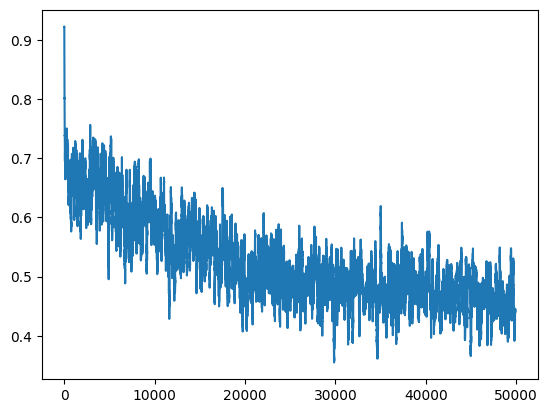

In [1]:
from core.spatial.energy_graph import PointEnergyMLP
from core.spatial.diffusion import samples, ScheduleLogLinear, training_loop, ScheduleDDPM


s_constraints = {
    "online" : [2]
}
model = PointEnergyMLP(s_constraints, dim = 2)

#model.load_state_dict(torch.load("outputs/checkpoints/state.pth", map_location = "cpu"))

from torch.utils.data import Dataset, DataLoader
from datasets.ccsp_dataset import Swissroll, collate_graph_batch
dataset = Swissroll(-10,10,N = 200)
loader = DataLoader(dataset, batch_size = 1000, collate_fn = collate_graph_batch)

schedule = ScheduleLogLinear(N=200, sigma_min=0.002, sigma_max=10)
#schedule = ScheduleDDPM(N = 200, beta_start = 0.0001, beta_end = 0.02)
trainer  = training_loop(loader, model, schedule, epochs=50000, lr = 0.001)

import numpy as np
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w


losses   = [ns.loss.item() for ns in trainer]
import matplotlib.pyplot as plt
plt.plot(moving_average(losses, 100))


torch.Size([])
torch.Size([1, 160, 2])


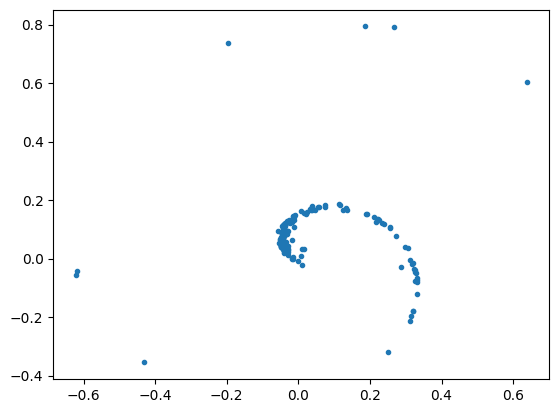

In [ ]:


import torch
batchsize = 160
cond = {"edges":[(i, "online") for i in range(batchsize)]}

xt = torch.randn([1,batchsize,2]) * schedule.sample_sigmas(100)[0]
*xt, x0  = samples(model, schedule.sample_sigmas(100), gam=1., cond = cond, batchsize = batchsize, xt = xt)

def plot_batch(batch):
    batch = batch.cpu().numpy()
    plt.scatter(batch[:,0], batch[:,1], marker='.')
print(x0.shape)
plot_batch(x0[0])